In [ ]:
# draw figures for NeurSC results

import seaborn as sns
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

def read_result_file(result_dir, params_dir, result_name):
    # model_data = [['Epochs', 'Train Query Number', 'Train Query Number Type', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    name_tokens = result_name.split('_')
    epochs = int(name_tokens[4])
    training_type = None
    training_prec = None
    train_query_suffix = ''
    if name_tokens[7] == 'aug':
        training_prec = name_tokens[9]
        if name_tokens[8] == '1':
            training_type = 'aug_1'
            train_query_suffix = 'All original\nqueries +\n{}% aug 1\nqueries'.format(training_prec)
        else:
            training_type = 'aug_2'
            train_query_suffix = 'All original\nqueries +\nall aug 1\nqueries +\n{}% aug 2\nqueries'.format(training_prec)
    else:
        training_type = 'original'
        training_prec = name_tokens[7]
        train_query_suffix = '{}% original\nqueries'.format(training_prec)
    res = []

    train_query_number = 0
    with open(params_dir + result_name, 'r') as f:
        for line in f.readlines():
            if line.startswith('training query number'):
                train_query_number = int(line.split(':')[1].strip())
                train_query_number = str(train_query_number) + '\n' + train_query_suffix
                break

    with open(result_dir + result_name, 'r') as f:
        for line in f.readlines()[1:]:
            line_tokens = line.split()
            query_name_tokens = line_tokens[0].split('.')[0].split('_')
            query_size = int(query_name_tokens[2])
            query_type = query_name_tokens[1]
            pred = float(line_tokens[2])
            card = float(line_tokens[3])
            if pred < card:
                q_error = -math.log10(float(line_tokens[1]))
            else:
                q_error = math.log10(float(line_tokens[1]))
            res.append([epochs, train_query_number, training_type + '_' + training_prec, query_size, query_type, pred, card, q_error])
    return res

def draw_box_plot(dataframe, title, fontsize=16):
    sns.set(rc={'figure.figsize':(20.7,8.27)})
    bp = sns.boxplot(data=df, x='Train Query Number', y='q-error', whis=[1, 99])
    vertical_lines = [8.5, 11.5]  # List of x-axis values where you want to add vertical line
    for line in vertical_lines:
        plt.axvline(x=line, color='red', linestyle='--')
    plt.grid(visible=True, linestyle='--')
    plt.title(title, fontsize=fontsize)
    plt.axhline(0, color='green',linestyle='dashed')
    plt.ylabel('Under estimate <--- q-error ---> Over estimate', fontsize=fontsize)
    plt.xlabel('Number of training queries', fontsize=fontsize)
    if title == 'yeast':
        plt.yticks(ticks=[-6, -4, -2, 0, 2, 4, 6], 
                   labels=['$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$'])
    elif title == 'youtube':    
        plt.yticks(ticks=[-8, -6, -4, -2, 0, 2, 4, 6, 8], 
                   labels=['$10^8$', '$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$'])
    elif title == 'wordnet':
        plt.yticks(ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], 
                   labels=['$10^5$', '$10^4$', '$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    elif title == 'eu2005':
        plt.yticks(ticks=[-3, -2, -1, 0, 1, 2, 3], 
                   labels=['$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'])
    else:
        raise Exception('Not recognized dataset')
    plt.ylabel('under estimate <--- q-error ---> over estimate')
    plt.xlabel('number of training queries')
    pcntls = df.groupby('Train Query Number')['q-error'].describe(percentiles=[0.1, 0.9])
    pcntls = pcntls.sort_values(by='Train Query Number', key=lambda x: x.apply(lambda y: int(y.split('\n')[0])))
    display(pcntls)
    columns = len(pcntls['10%'])
    bp.scatter(data=pcntls, x=range(columns), y='10%', marker='x')
    bp.scatter(data=pcntls, x=range(columns), y='90%', marker='x')
    plt.show()


def draw_line_plot(df, title, fontsize=16):
    medians = df.groupby(by=['Train Query Number', 'Epochs'])['q-error'].median().reset_index(name='median q-error')
    medians = medians.sort_values(by='Train Query Number', key=lambda x: x.apply(lambda y: int(y.split('\n')[0])))
    medians['median q-error'] = medians['median q-error'].abs()
    sns.lineplot(data=medians, x='Train Query Number', y='median q-error')
    plt.ylabel('log10(median q-error)', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.xlabel('Number of training queries', fontsize=fontsize)
    plt.tick_params(axis='y', labelsize=fontsize)
    plt.show()

if __name__ == '__main__':
    data_graph = 'yeast'
    result_dir = 'saved_results/'
    params_dir = 'saved_params/'
    # model_data = [['Epochs', 'Train Query Number', 'Train Query Number Type', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    model_data = []
    for file in os.listdir(result_dir):
        if file.startswith(data_graph):
            model_data.extend(read_result_file(result_dir, params_dir, file))
    df = pd.DataFrame(data=model_data, 
                      columns=['Epochs', 'Train Query Number', 'Train Query Number Type', 'Query Size', ' QueryType', 'Pred', 'Card', 'q-error'])
    df = df.loc[df['Epochs'] == 80]
    df = df.sort_values(by='Train Query Number', key=lambda x: x.apply(lambda y: int(y.split('\n')[0])))
    draw_box_plot(df, data_graph)
    draw_line_plot(df, data_graph)


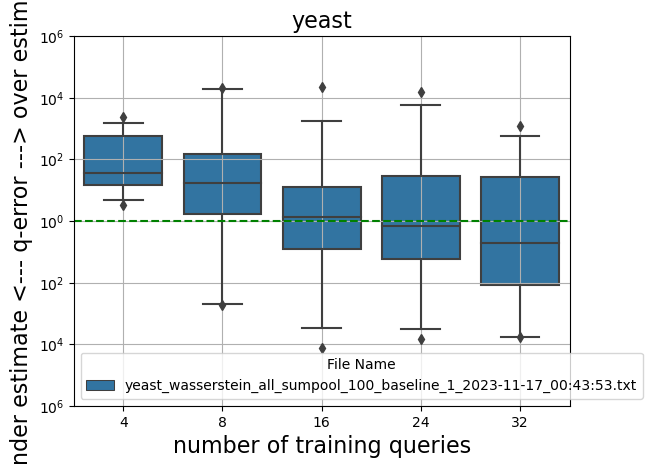

In [13]:
# draw figures for NeurSC results

import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

def read_result_file(result_dir, result_name):
    # model_data = [['File Name', 'Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    name_tokens = result_name.split('_')
    epochs = int(name_tokens[4])
    res = []

    with open(result_dir + result_name, 'r') as f:
        for line in f.readlines()[1:]:
            line_tokens = line.split()
            query_name_tokens = line_tokens[0].split('.')[0].split('_')
            query_size = int(query_name_tokens[2])
            query_type = query_name_tokens[1]
            pred = float(line_tokens[2])
            card = float(line_tokens[3])
            if pred < card:
                q_error = -math.log10(float(line_tokens[1]))
            else:
                q_error = math.log10(float(line_tokens[1]))
            res.append([result_name, epochs, query_size, query_type, pred, card, q_error])
    return res

def draw_box_plot(dataframe, title, fontsize=16):
    bp = sns.boxplot(data=dataframe, x='Query Size', y='q-error', whis=[1, 99], hue='File Name')
    plt.title(title, fontsize=fontsize)
    plt.grid(True)
    plt.axhline(0, color='green',linestyle='dashed')
    plt.ylabel('Under estimate <--- q-error ---> Over estimate', fontsize=fontsize)
    plt.xlabel('Query Size', fontsize=fontsize)
    if title == 'yeast':
        plt.yticks(ticks=[-6, -4, -2, 0, 2, 4, 6], 
                   labels=['$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$'])
    elif title == 'youtube':    
        plt.yticks(ticks=[-8, -6, -4, -2, 0, 2, 4, 6, 8], 
                   labels=['$10^8$', '$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$'])
    elif title == 'wordnet':
        plt.yticks(ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], 
                   labels=['$10^5$', '$10^4$', '$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    elif title == 'eu2005':
        plt.yticks(ticks=[-3, -2, -1, 0, 1, 2, 3], 
                   labels=['$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'])
    else:
        raise Exception('Not recognized dataset')
    plt.ylabel('under estimate <--- q-error ---> over estimate')
    plt.xlabel('number of training queries')
    # pcntls = df.groupby('Query Size')['q-error'].describe(percentiles=[0.1, 0.9])
    # pcntls = pcntls.sort_values(by='Query Size')
    # columns = len(pcntls['10%'])
    # bp.scatter(data=pcntls, x=range(columns), y='10%', marker='x')
    # bp.scatter(data=pcntls, x=range(columns), y='90%', marker='x')
    plt.show()

if __name__ == '__main__':
    data_graph = 'yeast'
    result_dir = 'saved_results/'
    params_dir = 'saved_params/'
    file_names = ['yeast_wasserstein_all_sumpool_100_baseline_1_2023-11-17_00:43:53.txt',]
    # model_data = [['Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    model_data = []
    for file_name in file_names:
        model_data.extend(read_result_file(result_dir, file_name))
    df = pd.DataFrame(data=model_data, 
                      columns=['File Name', 'Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'])
    df = df.sort_values(by='Query Size')
    draw_box_plot(df, data_graph)

In [31]:
# interpreting the test results
import os
import numpy as np
import math

def get_prediction_statistics(errors: list):
	lower, upper = np.quantile(errors, 0.25), np.quantile(errors, 0.75)
	print("<" * 80, flush=True)
	print("Predict Result Profile of {} Queries:".format(len(errors)), flush=True)
	print("Min/Max: {:.4f} / {:.4f}".format(np.min(errors), np.max(errors)), flush=True)
	print("Mean: {:.4f}".format(np.mean(errors)), flush=True)
	print("Median: {:.4f}".format(np.median(errors)), flush=True)
	print("25%/75% Quantiles: {:.4f} / {:.4f}".format(lower, upper), flush=True)
	print(">" * 80, flush=True)
	error_median = abs(upper - lower)
	return error_median

results_dir = './saved_results/'
file_names = ['yeast_wasserstein_all_sumpool_100_baseline_4_2023-11-17_04:56:33.txt']
log_func = math.log10

all_results = []
for file in os.listdir(results_dir):
    if file not in file_names:
         continue
    results = {} # results <- {name: [pred, true]}
    with open(results_dir + file) as f:
        for line in f.readlines():
            if line.startswith('f'):
                continue
            line = line.strip()
            tokens = line.split(' ')
            results[tokens[0]] = [float(tokens[2]), float(tokens[3])]
    all_results.append(results)

for results in all_results:
    if len(results) == 0:
         continue
    log2_q_errors = []
    total_log2_mse_loss = 0
    total_log2_l1_loss = 0
    count = 0
    for pred, card in results.values():
        if pred == 0:
             pred = 1
        pred_log2 = log_func(pred)
        card_log2 = log_func(card)
        log2_q_errors.append(pred_log2 - card_log2)
        total_log2_mse_loss += (pred_log2 - card_log2)**2
        total_log2_l1_loss += abs(pred_log2 - card_log2)
        count += 1
    print("Evaluation result of Eval dataset: Total Loss= {:.4f}, Total L1 Loss= {:.4f}".format(total_log2_mse_loss, total_log2_l1_loss))
    get_prediction_statistics(log2_q_errors)
    print()


Evaluation result of Eval dataset: Total Loss= 1040.4213, Total L1 Loss= 465.1595
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Predict Result Profile of 315 Queries:
Min/Max: -4.7212 / 4.1532
Mean: -0.0730
Median: 0.0707
25%/75% Quantiles: -1.2880 / 1.1791
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



In [ ]:
# clean the outputs env

import shutil
import os

shutil.rmtree('saved_models', ignore_errors=True)
shutil.rmtree('saved_params', ignore_errors=True)
shutil.rmtree('saved_results', ignore_errors=True)

os.mkdir('saved_models/')
os.mkdir('saved_params/')
os.mkdir('saved_results/')

shutil.rmtree('outputs', ignore_errors=True)
os.mkdir('outputs/')
os.mkdir('outputs/yeast/')